<a href="https://colab.research.google.com/github/devanshjoshi104/Andrej-YT-Lecture/blob/main/Lecture4_makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [69]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-12-30 13:07:30--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.6’

names.txt.6         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-12-30 13:07:30 (6.23 MB/s) - ‘names.txt.6’ saved [228145/228145]



In [70]:
words = open('names.txt', 'r').read().splitlines()

In [71]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [72]:
# params
sample_data_size = len(words)
# sample_data_size = 5
embedding_dim_size = 10
unique_objects_count = 27
block_size = 3
neural_net_nodes = 200

In [73]:
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


with what to multiply to w to not change the standard deviation after w@x
it is multiple by gain/root of (fanin of w)
i.e. if input of W is Win
then

> gain / root(Win)
in our case by
(5/3) / (30**0.5)



> Can also use batch normalization instead, which helps here
and it also acts as regulariser which prevents over fitting



In [74]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((unique_objects_count, embedding_dim_size), generator=g)
W1 = torch.randn((block_size * embedding_dim_size, neural_net_nodes), generator=g) *  (5/3)/ ((block_size * embedding_dim_size)**0.5)
# hpreact was getting much larger, causing more logits to be either 1 or -1 which made gradient 0, hence no learning. Hence made this small so hpreact comes closer to 0
# since using batch norm, that dont need b1
b1 = torch.randn(neural_net_nodes, generator=g) * 0.01
W2 = torch.randn((neural_net_nodes, unique_objects_count), generator=g)* 0.01  # to have uniformity initially in logits
b2 = torch.randn(unique_objects_count, generator=g) * 0.01

# batch normalization
bngain = torch.ones((1, neural_net_nodes))
bnbias = torch.zeros((1, neural_net_nodes))
bnmean_running = torch.zeros((1, neural_net_nodes))
bnstd_running = torch.ones((1, neural_net_nodes))

parameters = [C, W1, W2, b2, bnbias, bngain]
sum(p.nelement() for p in parameters)
for p in parameters:
  p.requires_grad = True

In [75]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # hpreact = embcat @ W1 + b1
  hpreact = embcat @ W1

  # batch normalization
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi



  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3142
  10000/ 200000: 2.1983
  20000/ 200000: 2.3373
  30000/ 200000: 2.4363
  40000/ 200000: 2.0120
  50000/ 200000: 2.2591
  60000/ 200000: 2.4776
  70000/ 200000: 2.1007
  80000/ 200000: 2.2789
  90000/ 200000: 2.1857
 100000/ 200000: 1.9473
 110000/ 200000: 2.2995
 120000/ 200000: 1.9838
 130000/ 200000: 2.4511
 140000/ 200000: 2.3840
 150000/ 200000: 2.1984
 160000/ 200000: 1.9732
 170000/ 200000: 1.8664
 180000/ 200000: 1.9974
 190000/ 200000: 1.8343


In [76]:
@torch.no_grad()
def get_loss(type):
  x,y = {'train':(Xtr, Ytr),
         'val':(Xdev, Ydev),
         'test':(Xte, Yte), }[type]
  emb = C[x]
  # hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
  hpreact = emb.view(emb.shape[0], -1) @ W1
  # bnmeani = hpreact.mean(0, keepdim=True)
  # bnstdi = hpreact.std(0, keepdim=True)
  # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h@W2 + b2
  loss = F.cross_entropy(logits, y)
  print(f'{type} loss: {loss.item()}')

In [77]:
get_loss('train')
get_loss('val')

train loss: 2.066570997238159
val loss: 2.105036973953247


In [78]:
# from lecture

In [91]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # embedding_dim_size
n_hidden = 100 # neural_net_nodes
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [93]:
max_steps = 2_00_000
batch_size = 32
lossi = []
ud = []

for k in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if k < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

   # track stats
  if k % 10000 == 0: # print every once in a while
    print(f'{k:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if k >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.1595


layer 1 (      Tanh): mean -0.03, std 0.87, saturated: 48.69%
layer 3 (      Tanh): mean -0.03, std 0.89, saturated: 55.31%
layer 5 (      Tanh): mean -0.02, std 0.90, saturated: 54.75%
layer 7 (      Tanh): mean -0.08, std 0.91, saturated: 56.56%
layer 9 (      Tanh): mean +0.01, std 0.83, saturated: 33.62%


Text(0.5, 1.0, 'activation distribution')

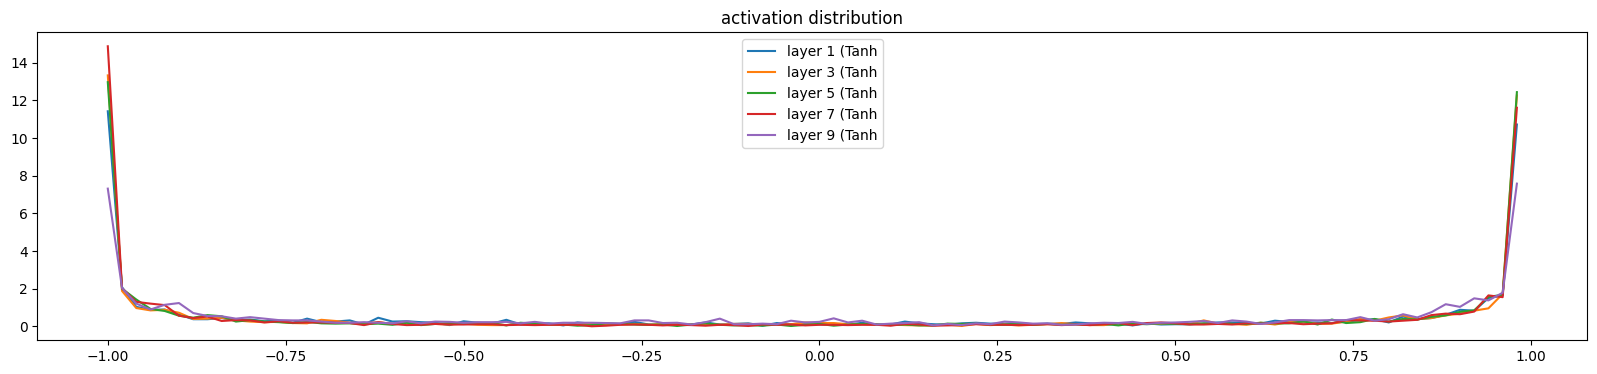

In [94]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000092, std 4.305052e-03
layer 3 (      Tanh): mean -0.000012, std 3.745642e-03
layer 5 (      Tanh): mean +0.000101, std 3.487000e-03
layer 7 (      Tanh): mean +0.000101, std 3.865431e-03
layer 9 (      Tanh): mean +0.000009, std 4.310658e-03


Text(0.5, 1.0, 'gradient distribution')

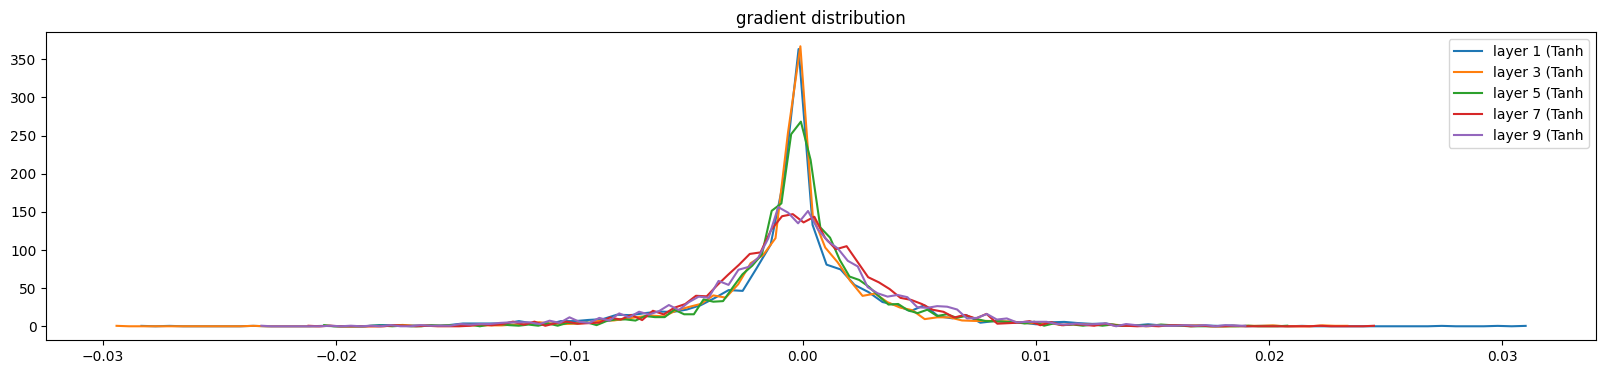

In [95]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000195 | std 1.880887e-02 | grad:data ratio 1.593792e-02
weight  (30, 100) | mean +0.000049 | std 1.172251e-02 | grad:data ratio 2.513079e-02
weight (100, 100) | mean +0.000056 | std 7.040659e-03 | grad:data ratio 2.540729e-02
weight (100, 100) | mean -0.000068 | std 6.584287e-03 | grad:data ratio 2.464827e-02
weight (100, 100) | mean +0.000078 | std 6.293733e-03 | grad:data ratio 2.404520e-02
weight (100, 100) | mean +0.000059 | std 7.631545e-03 | grad:data ratio 3.337949e-02
weight  (100, 27) | mean -0.000000 | std 2.601967e-02 | grad:data ratio 1.528429e-01


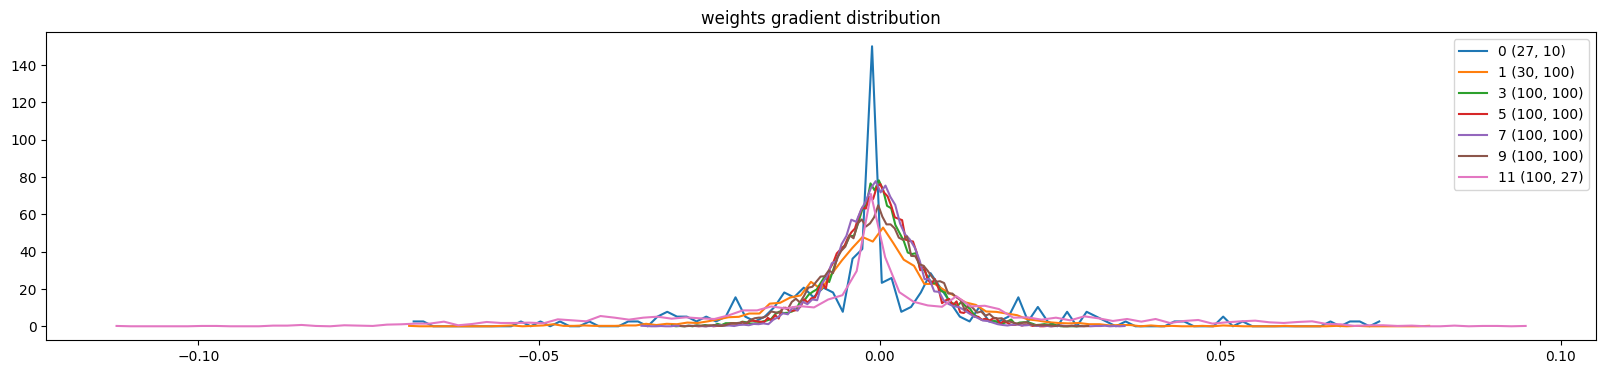

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

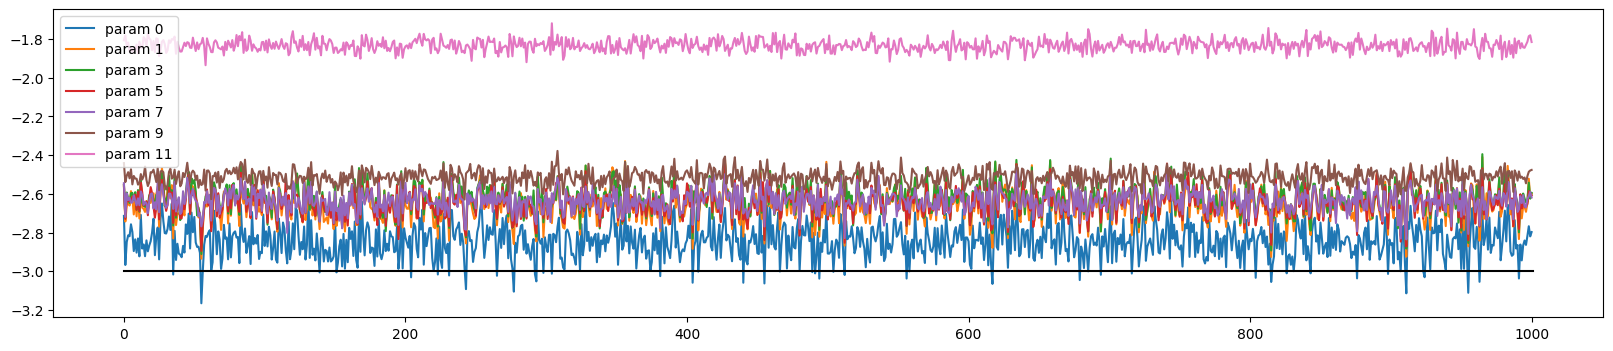

In [97]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
